## Introduction

In this notebook, we analyze an A/B testing dataset for a mobile game ("Cookie Cats").
 We will:
  1. Load and explore the data.
  2. Calculate retention rates (Day 1 and Day 7) for two versions of the game (gate_30 vs gate_40).
  3. Perform hypothesis tests (Chi-Square and Z-tests) to determine if the retention rates
     differ significantly between the two versions.
  4. Conduct a power analysis to understand the statistical power of our tests.
  5. Detect and remove outliers from numerical features (sum_gamerounds), then analyze the impact
     of outlier removal on correlation and on the results of a Z-test for sum_gamerounds.
  6. Compare the results with outliers vs. without outliers.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from scipy.stats import norm, chi2_contingency, zscore

# 1. Data Loading and Initial Overview

In [4]:
data = pd.read_csv('/kaggle/input/mobile-games-ab-testing/cookie_cats.csv')

print("### DATA HEAD ###")
print(data.head())

print("\n### DATA DESCRIPTION ###")
print(data.describe())

# Check the basic structure of the dataset
print("\n### DATA INFO ###")
print(data.info())

### DATA HEAD ###
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

### DATA DESCRIPTION ###
             userid  sum_gamerounds
count  9.018900e+04    90189.000000
mean   4.998412e+06       51.872457
std    2.883286e+06      195.050858
min    1.160000e+02        0.000000
25%    2.512230e+06        5.000000
50%    4.995815e+06       16.000000
75%    7.496452e+06       51.000000
max    9.999861e+06    49854.000000

### DATA INFO ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   ve

# 2. Retention Rate Calculations

In [5]:
v30_data = data[data['version'] == 'gate_30']
v40_data = data[data['version'] == 'gate_40']

retention_1_rate_v30 = v30_data['retention_1'].mean() * 100
retention_7_rate_v30 = v30_data['retention_7'].mean() * 100
retention_1_rate_v40 = v40_data['retention_1'].mean() * 100
retention_7_rate_v40 = v40_data['retention_7'].mean() * 100

print("\n### RETENTION RATES ###")
print(f"Gate_30: Day 1 = {retention_1_rate_v30:.2f}%, Day 7 = {retention_7_rate_v30:.2f}%")
print(f"Gate_40: Day 1 = {retention_1_rate_v40:.2f}%, Day 7 = {retention_7_rate_v40:.2f}%")



### RETENTION RATES ###
Gate_30: Day 1 = 44.82%, Day 7 = 19.02%
Gate_40: Day 1 = 44.23%, Day 7 = 18.20%


# 3. Hypothesis Testing
 We will perform two types of tests on Day 1 and Day 7 retention:
   1) Chi-Square Test (non-parametric, based on contingency tables).
   2) Z-Test for proportions (common in A/B tests).

 Null Hypothesis (H0) example for Day 1: 
   "There is no difference in Day 1 retention rate between gate_30 and gate_40."
 Alternate Hypothesis (H1):
   "There is a difference in Day 1 retention rate between gate_30 and gate_40."


In [8]:
# --- 3.1 Define a helper function for Z-test on proportions ---
def z_test_proportions(df, version_col, retention_col, alpha=0.05):
    """
    Performs a two-sided Z-test for difference in proportions between 
    two groups (gate_30 vs gate_40).
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing the data.
    version_col : str
        Column name that specifies the version/groups (e.g. 'gate_30' or 'gate_40').
    retention_col : str
        Column name for the retention binary metric (True/False).
    alpha : float
        Significance level for the test (default 0.05).
    
    Returns:
    --------
    Prints the results of the Z-test (Z-statistic, p-value, conclusion).
    """
    v30 = df[df[version_col] == 'gate_30']
    v40 = df[df[version_col] == 'gate_40']
    
    p1 = v30[retention_col].mean()
    p2 = v40[retention_col].mean()
    n1 = len(v30)
    n2 = len(v40)
    
    # Standard Error
    SE = math.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2))
    
    # Z statistic
    z_stat = (p1 - p2) / SE
    
    # Critical z-value for two-sided test
    z_alpha = norm.ppf(1 - alpha/2)
    
    # Compute p-value from z_stat
    # For a two-sided test, p-value = 2 * P(Z > |z_stat|)
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))
    
    # Decision
    if abs(z_stat) > z_alpha:
        conclusion = "Reject H0: There is a significant difference."
    else:
        conclusion = "Fail to Reject H0: No significant difference."
        
    print(f"=== Z-Test for {retention_col} ===")
    print(f"Proportion Gate_30 = {p1*100:.2f}%")
    print(f"Proportion Gate_40 = {p2*100:.2f}%")
    print(f"Z-Statistic = {z_stat:.2f}, Z-Critical (alpha={alpha}) = ±{z_alpha:.2f}")
    print(f"P-value = {p_value:.4f}")
    print(conclusion)
    print("-"*50)


def chi_square_test(df, version_col, retention_col, alpha=0.05):
    """
    Performs a chi-square test of independence on a 2x2 contingency table 
    and visualizes the contingency table with a heatmap.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing the data.
    version_col : str
        Column name that specifies the version/groups (e.g., 'gate_30', 'gate_40').
    retention_col : str
        Column name for the retention binary metric (True/False).
    alpha : float
        The significance level for the test (default 0.05).
    """
    # Contingency Table
    contingency = pd.crosstab(df[version_col], df[retention_col])
    
    # Chi-Square Test
    chi2, p_val, dof, expected = chi2_contingency(contingency)
    
    # Print Results
    print(f"=== Chi-Square Test for {retention_col} ===")
    print("Contingency Table (Observed):")
    print(contingency)
    print("\nExpected Frequencies (Rounded):")
    print(pd.DataFrame(expected, index=contingency.index, columns=contingency.columns).round(2))
    print(f"\nChi2 Statistic = {chi2:.4f}, P-value = {p_val:.4f}, Degrees of Freedom = {dof}")
    
    if p_val < alpha:
        conclusion = "Reject H0: There is a significant difference."
    else:
        conclusion = "Fail to Reject H0: No significant difference."
    print(conclusion)
    print("-" * 50)


In [9]:
# --- 3.3 Run the tests for Day 1 and Day 7 ---
print("\n### CHI-SQUARE TESTS ###")
chi_square_test(data, 'version', 'retention_1')
chi_square_test(data, 'version', 'retention_7')


### CHI-SQUARE TESTS ###
=== Chi-Square Test for retention_1 ===
Contingency Table (Observed):
retention_1  False  True 
version                  
gate_30      24666  20034
gate_40      25370  20119

Expected Frequencies (Rounded):
retention_1     False     True 
version                        
gate_30      24799.14  19900.86
gate_40      25236.86  20252.14

Chi2 Statistic = 3.1591, P-value = 0.0755, Degrees of Freedom = 1
Fail to Reject H0: No significant difference.
--------------------------------------------------
=== Chi-Square Test for retention_7 ===
Contingency Table (Observed):
retention_7  False  True 
version                  
gate_30      36198   8502
gate_40      37210   8279

Expected Frequencies (Rounded):
retention_7    False   True 
version                     
gate_30      36382.9  8317.1
gate_40      37025.1  8463.9

Chi2 Statistic = 9.9591, P-value = 0.0016, Degrees of Freedom = 1
Reject H0: There is a significant difference.
---------------------------------------

In [10]:
print("### Z-TESTS FOR PROPORTIONS ###")
z_test_proportions(data, 'version', 'retention_1', alpha=0.05)
z_test_proportions(data, 'version', 'retention_7', alpha=0.05)


### Z-TESTS FOR PROPORTIONS ###
=== Z-Test for retention_1 ===
Proportion Gate_30 = 44.82%
Proportion Gate_40 = 44.23%
Z-Statistic = 1.78, Z-Critical (alpha=0.05) = ±1.96
P-value = 0.0744
Fail to Reject H0: No significant difference.
--------------------------------------------------
=== Z-Test for retention_7 ===
Proportion Gate_30 = 19.02%
Proportion Gate_40 = 18.20%
Z-Statistic = 3.16, Z-Critical (alpha=0.05) = ±1.96
P-value = 0.0016
Reject H0: There is a significant difference.
--------------------------------------------------


# 4. Power Analysis & Minimum Detectable Effect (Combined with Z-Test)
 We'll create a helper function to compute MDE, power, etc. 
 This reuses the logic above but also returns power calculations.

In [11]:
def ab_test_power(df, version_col, retention_col, alpha=0.05):
    v30 = df[df[version_col] == 'gate_30']
    v40 = df[df[version_col] == 'gate_40']
    
    p1 = v30[retention_col].mean()
    p2 = v40[retention_col].mean()
    n1 = len(v30)
    n2 = len(v40)
    
    # Standard Error
    SE = math.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2))
    
    # Difference in proportions
    diff = abs(p1 - p2)
    
    # MDE (Minimum Detectable Effect) is simply the difference here
    MDE = diff
    
    # Z-Effect
    z_effect = diff / SE
    
    # Z-Alpha
    z_alpha = norm.ppf(1 - alpha/2)
    
    # Power Calculation
    # z_beta = z_alpha - z_effect => power = 1 - cdf(z_beta)
    z_beta = z_alpha - abs(z_effect)
    power = 1 - norm.cdf(z_beta)
    
    print(f"=== Power Analysis for {retention_col} ===")
    print(f"Sample Size Gate_30 = {n1}, Gate_40 = {n2}")
    print(f"Proportion Gate_30 = {p1*100:.2f}%, Gate_40 = {p2*100:.2f}%")
    print(f"Standard Error = {SE:.4f}")
    print(f"Observed Difference (MDE) = {MDE:.4f}")
    print(f"Z-Effect = {z_effect:.2f}, Z-Alpha = {z_alpha:.2f}")
    print(f"Estimated Power = {power:.2f}")
    print("-"*50)


In [12]:
print("\n### POWER ANALYSIS ###")
ab_test_power(data, 'version', 'retention_1')
ab_test_power(data, 'version', 'retention_7')


### POWER ANALYSIS ###
=== Power Analysis for retention_1 ===
Sample Size Gate_30 = 44700, Gate_40 = 45489
Proportion Gate_30 = 44.82%, Gate_40 = 44.23%
Standard Error = 0.0033
Observed Difference (MDE) = 0.0059
Z-Effect = 1.78, Z-Alpha = 1.96
Estimated Power = 0.43
--------------------------------------------------
=== Power Analysis for retention_7 ===
Sample Size Gate_30 = 44700, Gate_40 = 45489
Proportion Gate_30 = 19.02%, Gate_40 = 18.20%
Standard Error = 0.0026
Observed Difference (MDE) = 0.0082
Z-Effect = 3.16, Z-Alpha = 1.96
Estimated Power = 0.89
--------------------------------------------------


# 5. Outlier Detection and Removal
 We will look at the 'sum_gamerounds' feature, draw a boxplot, and identify outliersusing z-scores. 
 
Then, we will analyze correlation changes with and without outliers.



### OUTLIER DETECTION ###


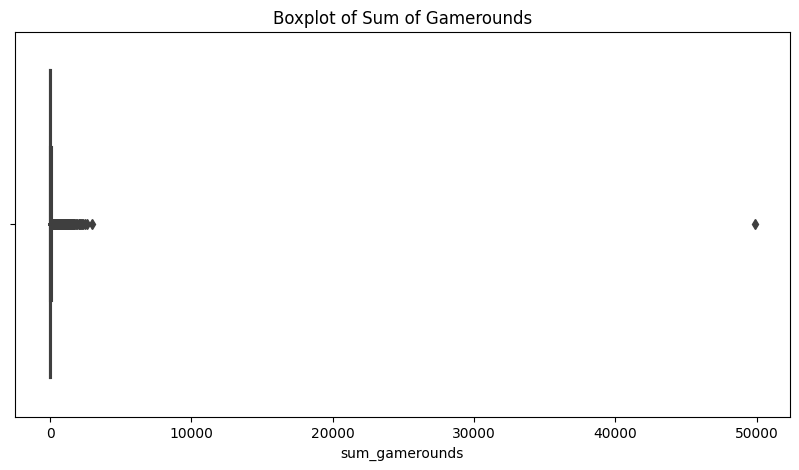

In [13]:
print("\n### OUTLIER DETECTION ###")
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['sum_gamerounds'])
plt.title('Boxplot of Sum of Gamerounds')
plt.show()


Number of outliers (z_score > 3): 425


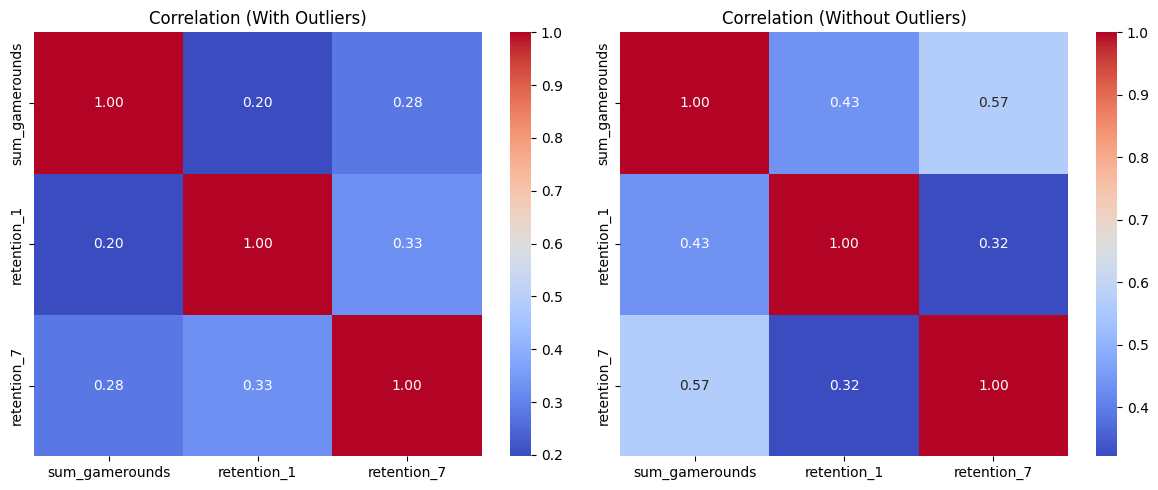

In [14]:
# Calculate Z-scores
data['z_score'] = zscore(data['sum_gamerounds'])

# Define outliers as z_score > 3 (a common threshold)
outliers = data[data['z_score'] > 3]
print(f"Number of outliers (z_score > 3): {outliers.shape[0]}")

# Compare correlation with and without outliers
correlation_with_outliers = data[['sum_gamerounds','retention_1','retention_7']].corr()
data_filtered = data[data['z_score'] <= 3]  # remove outliers
correlation_without_outliers = data_filtered[['sum_gamerounds','retention_1','retention_7']].corr()
# Plot correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(correlation_with_outliers, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title("Correlation (With Outliers)")

sns.heatmap(correlation_without_outliers, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
axes[1].set_title("Correlation (Without Outliers)")

plt.tight_layout()
plt.show()

# 6. Sum of Gamerounds Analysis (With and Without Outliers)

-We want to see if the average sum_gamerounds differs between gate_30 and gate_40.


-We'll perform a two-sample Z-test on the means. Technically, a t-test is more common for comparing means, but we'll follow the original approach to maintain consistency.

In [15]:
def z_test_means(df, version_col, numeric_col, alpha=0.05):
    """
    Performs a Z-test for difference of means between two groups 
    (gate_30 vs gate_40) assuming large sample sizes.
    """
    v30 = df[df[version_col] == 'gate_30']
    v40 = df[df[version_col] == 'gate_40']
    
    mean_v30 = v30[numeric_col].mean()
    mean_v40 = v40[numeric_col].mean()
    std_v30 = v30[numeric_col].std()
    std_v40 = v40[numeric_col].std()
    n_v30 = len(v30)
    n_v40 = len(v40)
    
    # Standard Error for difference of means
    SE = math.sqrt((std_v30**2 / n_v30) + (std_v40**2 / n_v40))
    
    # Z statistic
    z_stat = (mean_v30 - mean_v40) / SE
    
    # Critical Z value
    z_alpha = norm.ppf(1 - alpha/2)
    
    # P-value for two-sided test
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))
    
    # Conclusion
    if abs(z_stat) > z_alpha:
        conclusion = "Reject H0: There's a significant difference in means."
    else:
        conclusion = "Fail to Reject H0: No significant difference in means."
    
    print(f"=== Z-Test for Means: {numeric_col} ===")
    print(f"Gate_30 Mean = {mean_v30:.2f}, Gate_40 Mean = {mean_v40:.2f}")
    print(f"Z-Statistic = {z_stat:.2f}, Z-Critical = ±{z_alpha:.2f}")
    print(f"p-value = {p_value:.4f}")
    print(conclusion)
    print("-"*50)

In [16]:
print("\n### SUM_OF_GAMEROUNDS ANALYSIS (WITH OUTLIERS) ###")
z_test_means(data, 'version', 'sum_gamerounds')

print("\n### SUM_OF_GAMEROUNDS ANALYSIS (WITHOUT OUTLIERS) ###")
z_test_means(data_filtered, 'version', 'sum_gamerounds')



### SUM_OF_GAMEROUNDS ANALYSIS (WITH OUTLIERS) ###
=== Z-Test for Means: sum_gamerounds ===
Gate_30 Mean = 52.46, Gate_40 Mean = 51.30
Z-Statistic = 0.89, Z-Critical = ±1.96
p-value = 0.3759
Fail to Reject H0: No significant difference in means.
--------------------------------------------------

### SUM_OF_GAMEROUNDS ANALYSIS (WITHOUT OUTLIERS) ###
=== Z-Test for Means: sum_gamerounds ===
Gate_30 Mean = 47.49, Gate_40 Mean = 46.95
Z-Statistic = 0.99, Z-Critical = ±1.96
p-value = 0.3207
Fail to Reject H0: No significant difference in means.
--------------------------------------------------


# 8. Handling Users Who just downloaded the game but never played


In [17]:
# Let's quickly see how many such users are in each version:
never_played = data[data['sum_gamerounds'] == 0]
print("\n### NEVER PLAYED USERS ###")
print(f"Total never-played users: {len(never_played)}")
print("Breakdown by version:")
print(never_played['version'].value_counts())



### NEVER PLAYED USERS ###
Total never-played users: 3994
Breakdown by version:
version
gate_40    2057
gate_30    1937
Name: count, dtype: int64


# 9. Testing the User Segmentation 

# 9.1. Categorize Retention


In [18]:
def categorize_retention(row):
    """
    Return a string label indicating whether the user
    retained on Day 1 only, Day 7 only, Both, or None.
    """
    r1 = row['retention_1']
    r7 = row['retention_7']
    
    if (not r1) and (not r7):
        return "None"
    elif r1 and (not r7):
        return "Day1Only"
    elif (not r1) and r7:
        return "Day7Only"
    else:
        return "Both"

data['retention_category'] = data.apply(categorize_retention, axis=1)


# 9.2. Bin sum_gamerounds


In [19]:
bin_edges = [0, 10, 50, 100, 500, 1000, 5000, data['sum_gamerounds'].max()]
data['round_bin'] = pd.cut(data['sum_gamerounds'], bins=bin_edges, include_lowest=True)


df_grouped = (
    data.groupby(['version', 'round_bin', 'retention_category'])
    .size()
    .reset_index(name='user_count')
)

<ipython-input-19-5b0bdb8d06d2>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['version', 'round_bin', 'retention_category'])


# 9.4. Plot Separate Bar Charts for Each Version


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_

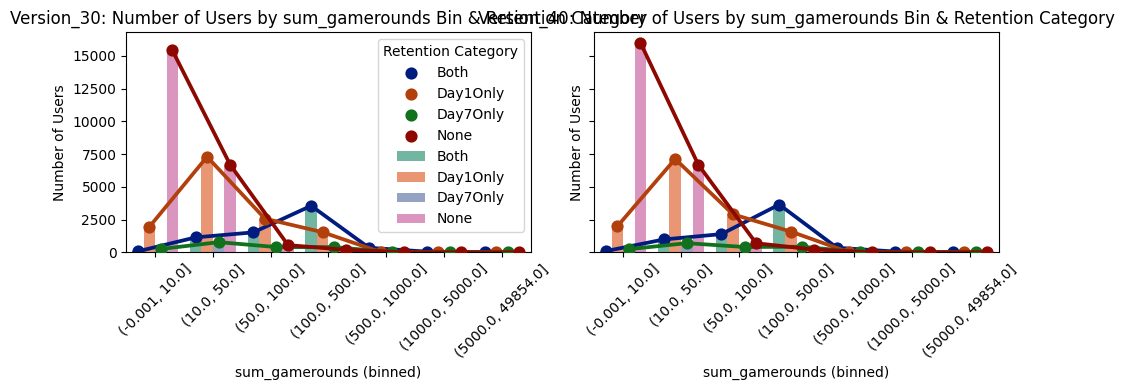

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate datasets
gate_30_data = df_grouped[df_grouped['version'] == 'gate_30'].copy()
gate_40_data = df_grouped[df_grouped['version'] == 'gate_40'].copy()

# Create subplots side by side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

# --- A. Gate_30 ---
sns.barplot(
    data=gate_30_data,
    x='round_bin',
    y='user_count',
    hue='retention_category',
    palette='Set2',
    ax=axs[0],
    dodge=True
)
sns.pointplot(
    data=gate_30_data,
    x='round_bin',
    y='user_count',
    hue='retention_category',
    palette='dark',   # or any other palette for the line/markers
    dodge=0.6,        # match or slightly exceed the barplot dodge
    join=True,        # connect points with lines
    markers='o',
    ax=axs[0]
)
axs[0].set_title("Version_30: Number of Users by sum_gamerounds Bin & Retention Category")
axs[0].set_xlabel("sum_gamerounds (binned)")
axs[0].set_ylabel("Number of Users")
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend(title="Retention Category", loc='upper right')

# --- B. Gate_40 ---
sns.barplot(
    data=gate_40_data,
    x='round_bin',
    y='user_count',
    hue='retention_category',
    palette='Set2',
    ax=axs[1],
    dodge=True
)
sns.pointplot(
    data=gate_40_data,
    x='round_bin',
    y='user_count',
    hue='retention_category',
    palette='dark',   # or any other palette for the line/markers
    dodge=0.6,
    join=True,
    markers='o',
    ax=axs[1]
)
axs[1].set_title("Version_40: Number of Users by sum_gamerounds Bin & Retention Category")
axs[1].set_xlabel("sum_gamerounds (binned)")
axs[1].set_ylabel("Number of Users")
axs[1].tick_params(axis='x', rotation=45)
# Remove the second legend if you prefer a single combined legend:
axs[1].legend_.remove()

plt.tight_layout()
plt.show()


Taking a closer look the graphs to see the patterns

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


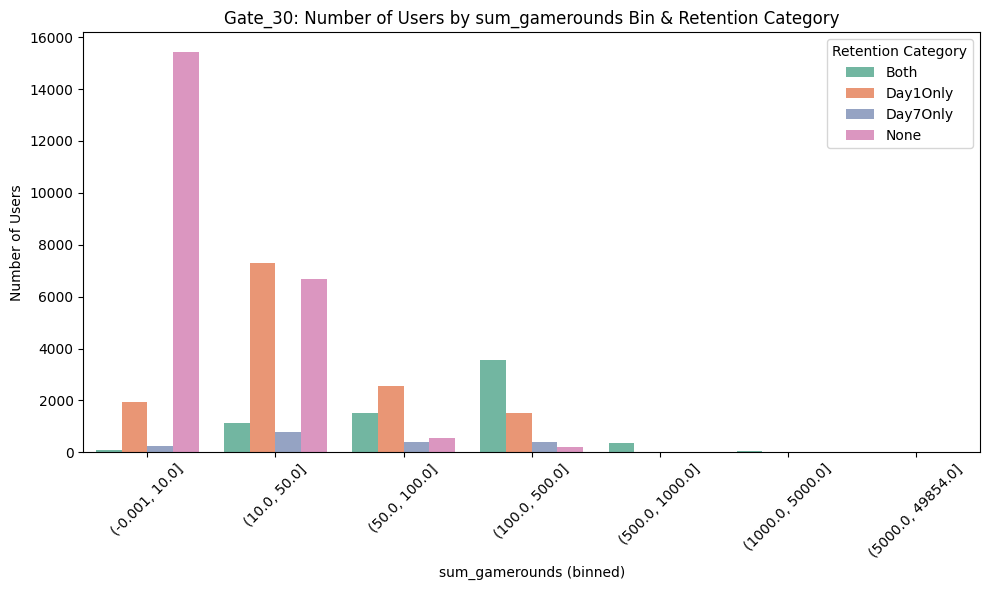

In [21]:
# --- A. Gate_30 ---
gate_30_data = df_grouped[df_grouped['version'] == 'gate_30'].copy()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=gate_30_data,
    x='round_bin', 
    y='user_count',
    hue='retention_category',
    palette='Set2'
)
plt.title("Gate_30: Number of Users by sum_gamerounds Bin & Retention Category")
plt.xlabel("sum_gamerounds (binned)")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)  # rotate x-axis labels if they overlap
plt.legend(title="Retention Category")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


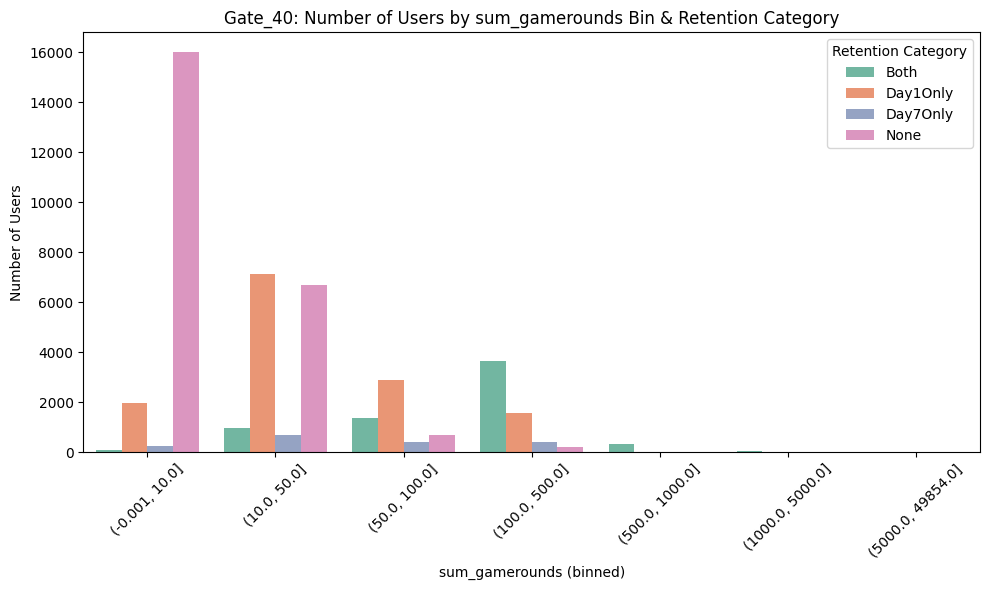

In [23]:
# --- B. Gate_40 ---
gate_40_data = df_grouped[df_grouped['version'] == 'gate_40'].copy()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=gate_40_data,
    x='round_bin', 
    y='user_count',
    hue='retention_category',
    palette='Set2'
)
plt.title("Gate_40: Number of Users by sum_gamerounds Bin & Retention Category")
plt.xlabel("sum_gamerounds (binned)")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.legend(title="Retention Category")
plt.tight_layout()
plt.show()

As we can see there is great accumulation of people who retained both of the days between the levels of 100-500 and 500-1000 therefore the firm come with strategies such as promotion of ad-free options 

# Key Findings and Conclusion

1. Result of A/B test : gate_30 version of the games provides better user loyalty in terms of 7 day retentions.
2. The played game rounds and long term of usage of the app is correlated
3. New bussiness strategies can be developed for the users above the level 100

Thanks for looking this notebook I hope it helped I am open for any kinf of feedback and comment. 

github: https://github.com/MUSERC